In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.optimize import curve_fit
from skimage import filters
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
from cfilt.utils import *

In [3]:
ds = CDS(
    [1, 4, 16, 1600],
    "jx",
    "../out/",
    normalize=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

In [4]:
crop = lambda x: x[3:-1, 3:-2]

In [229]:
im1 = crop(ds.images[1][10])
im4 = crop(ds.images[4][10])
im16 = crop(ds.images[16][10])
im1600 = crop(ds.images[1600][10])

In [230]:
def qplot(ims, fn=None):
    if fn is not None:
        ims = list(map(fn, ims))
    n = len(ims)
    fig, ax = plt.subplots(1, n, figsize=(2 + 3 * n, 3.5))
    for i in range(n):
        ax[i].pcolormesh(ims[i])

In [231]:
fft2d = lambda x: np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))
ifft2d = lambda x: np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(x))).real

In [237]:
ims = [im1, im1600]

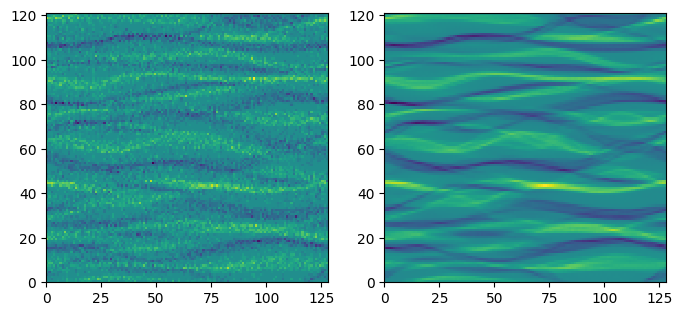

In [238]:
qplot(ims)

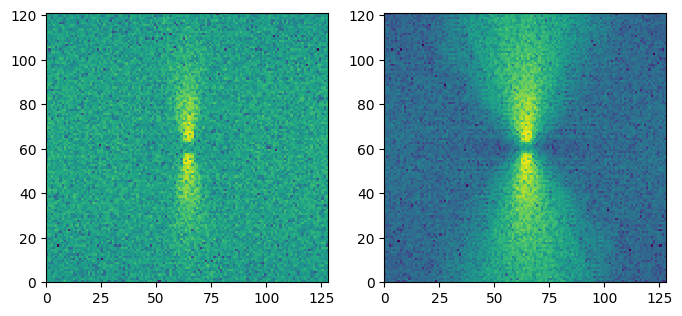

In [239]:
qplot(ims, lambda x: np.log(np.abs(fft2d(x))))

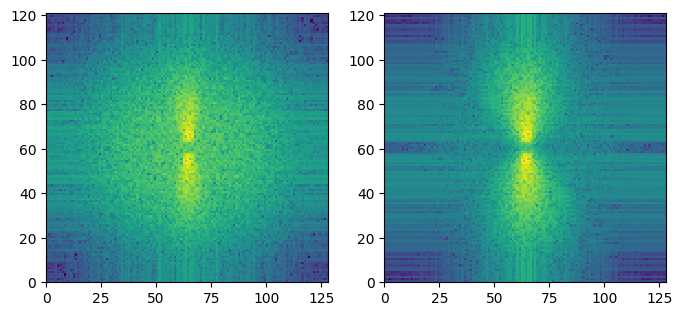

In [241]:
qplot(ims, lambda x: np.log(np.abs(fft2d(ndimage.gaussian_filter(x, sigma=1)))))

In [320]:
def create_circular_mask(h, w, center=None, radius=None, weights=(1, 1)):

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt(
        weights[0] * (X - center[0]) ** 2 + weights[1] * (Y - center[1]) ** 2
    )

    mask = dist_from_center <= radius
    return mask

In [264]:
chunks = im1.reshape(11, 11, 8, 16).swapaxes(1, 2)

In [271]:
# msk = create_circular_mask(11, 64, radius=10)
fftchunks = []
reconchunks = []
for i in range(chunks.shape[0]):
    buffer = []
    buffer2 = []
    for j in range(chunks.shape[1]):
        chunkfft = fft2d(chunks[i, j])
        qtl = np.quantile(np.abs(chunkfft), 0.7)
        msk = np.abs(chunkfft) < qtl
        chunkfft[msk] = 0
        buffer.append(chunkfft)
        chunkfft = ifft2d(chunkfft)
        buffer2.append(chunkfft)
    fftchunks.append(np.stack(buffer))
    reconchunks.append(np.stack(buffer2))
fftchunks = np.stack(fftchunks)
reconchunks = np.stack(reconchunks)
fftchunks.shape, reconchunks.shape

((11, 8, 11, 16), (11, 8, 11, 16))

/tmp/ipykernel_1174748/2174878217.py:1: RuntimeWarning: divide by zero encountered in log
  qplot((chunks[0][0], np.log(np.abs(fftchunks[0][0])), reconchunks[0][0]))


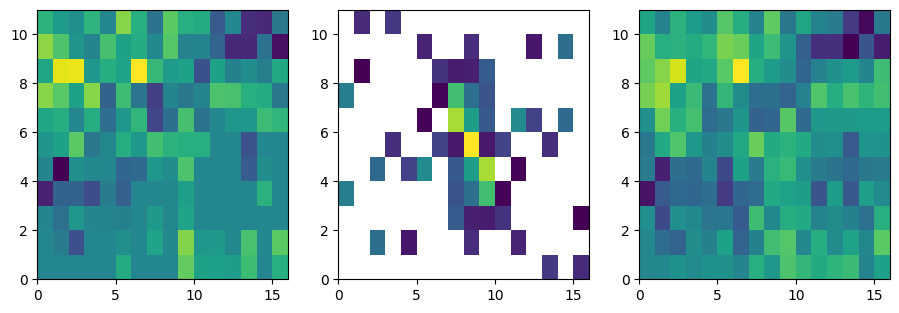

In [301]:
qplot((chunks[0][0], np.log(np.abs(fftchunks[0][0])), reconchunks[0][0]))

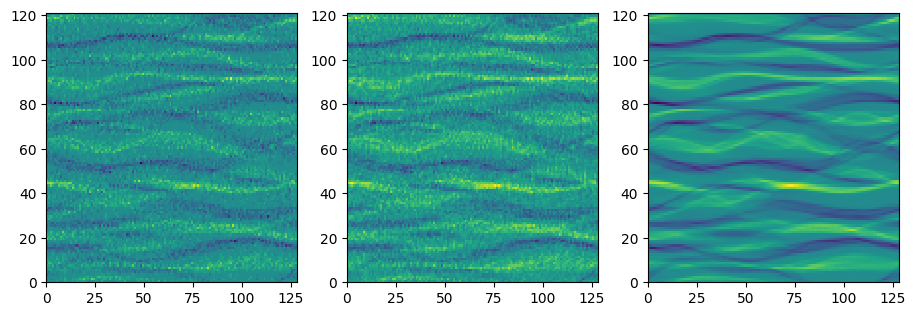

In [302]:
qplot((im1, reconchunks.swapaxes(1, 2).reshape(*im1.shape), im1600))

In [303]:
norms = []
for q in np.linspace(0, 1):
    imfft = fft2d(im1)
    imfft[np.abs(imfft) < np.quantile(np.abs(imfft), q)] = 0
    norms.append(np.linalg.norm(ifft2d(imfft) - im1600))
norms = np.array(norms)

0.8979591836734693

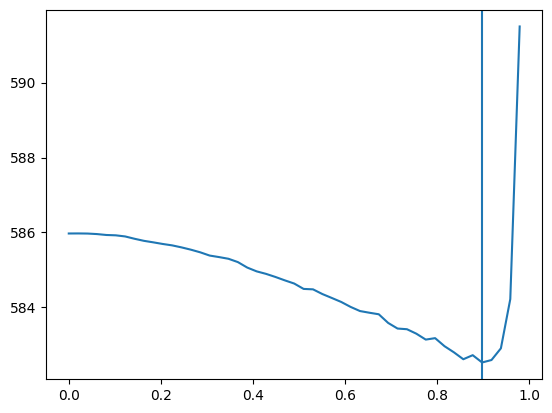

In [304]:
plt.plot(np.linspace(0, 1)[:-1], norms[:-1])
best = np.linspace(0, 1)[np.argmin(norms)]
plt.axvline(best)
best

/tmp/ipykernel_1174748/3417940455.py:5: RuntimeWarning: divide by zero encountered in log
  qplot([im1, mk, np.log(np.abs(imfft)), ifft2d(imfft), im1600])


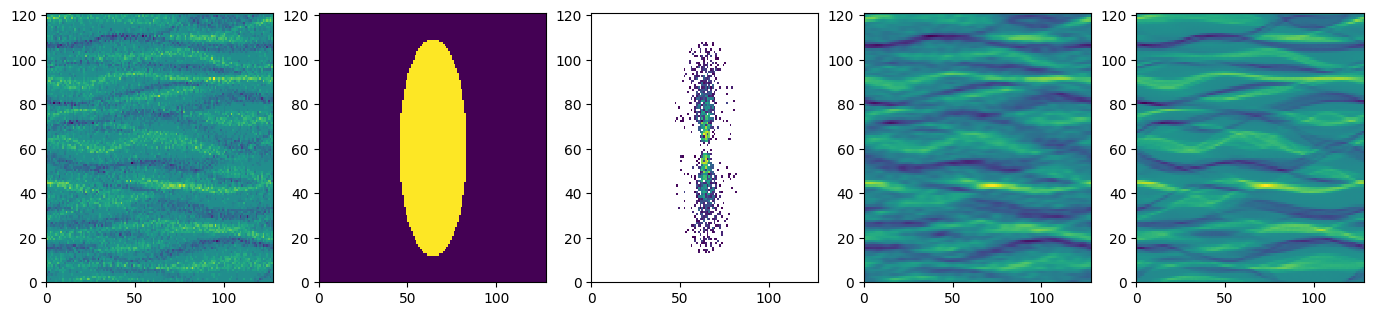

In [354]:
imfft = fft2d(im1)
imfft[np.abs(imfft) < np.quantile(np.abs(imfft), best)] = 0
mk = create_circular_mask(*im1.shape, weights=(10, 1.5))
imfft[~mk] = 0
qplot([im1, mk, np.log(np.abs(imfft)), ifft2d(imfft), im1600])